<a href="https://colab.research.google.com/github/abdulsamadkhan/AlignmentTuning/blob/main/Instruction_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Instruction-Tuning with LLMs


Instruction-based fine-tuning is a process where a pre-trained language model is further trained (fine-tuned) using instruction–response pairs. These pairs consist of a task description (instruction + context) and an appropriate answer (output). The idea is to make the model better at following natural language instructions—essentially training it to behave like a helpful assistant.



In instruction tuning datasets like Alpaca, each example is typically a triplet (or close variant)
```
{
  "instruction": "...",
  "input": "...",
  "output": "..."
}
```

This format is used across different task and here is an example of some of the tasks.

**Template: QA-style promp**
```
{
  "instruction": "Answer the question.",
  "input": "What is the capital of France?",
  "output": "The capital of France is Paris."
}

```
**Template: Text Generation**
```
{
  "instruction": "Write a story about a dragon who learns to paint.",
  "input": "",
  "output": "Once upon a time in the hills of Eldara, a young dragon named Thalos discovered a set of magical brushes..."
}

```
**Template: Summarization**
```
{
  "instruction": "Summarize the following article.",
  "input": "The recent advancements in AI have led to significant improvements in language understanding and generation...",
  "output": "Recent AI advancements have greatly improved language understanding and generation."
}

```


**Conversation Template (Multi-turn Chat Style)**
```
{
  "instruction": "You are a helpful assistant.",
  "input": "User: What's the weather like in Paris?\nAssistant: It's currently sunny and 22°C.\nUser: Great! Should I carry an umbrella?",
  "output": "Assistant: It’s unlikely to rain today, but carrying a small umbrella just in case is always a good idea."
}

```






## Objectives

After completing this lab, you will be able to:

 - Understand the various types of templates including instruction-response, question-answering, summarization, code generation, dialogue, data analysis, and explanation and their applications for fine-tuning large language models (LLMs).
 - Create and apply different templates to fine-tune LLMs for various tasks.
 - Format datasets based on the created templates to prepare them for effective model training
 - Perform instruction fine-tuning using Hugging Face libraries and tools
 - Apply Low-Rank Adaptation (LoRA) techniques to fine-tune LLMs efficiently
 - Configure and use the SFTTrainer for supervised fine-tuning of instruction-following models


The concepts presented in this lab would apply to the other template formats as well.


# Table of Contents

1. [Setup](#Setup)
    1. [Install required libraries](#Install-required-libraries)
    2. [Import required libraries](#Import-required-libraries)
    3. [Define the device](#Define-the-device)
2. [Dataset description](#Dataset-description)
3. [Model and tokenizer](#Model-and-tokenizer)
4. [Preprocessing the data](#Preprocessing-the-data)
5. [Test the base model](#Test-the-base-model)
    1. [BLEU score](#BLEU-score)
6. [Perform instruction fine-tuning with LoRA](#Perform-instruction-fine-tuning-with-LoRA)
7. [Exercises](#Exercises)

# Setup

### Install required libraries

For this lab, use the following libraries


In [1]:
!pip install  datasets
!pip install  trl
!pip install transformers
!pip install  peft
!pip install  tqdm
!pip install  numpy
!pip install  pandas
!pip install  matplotlib
!pip install  seaborn
!pip install  scikit-learn
!pip install  sacrebleu
!pip install  evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

### Import required libraries

The following code imports the required libraries.


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt

from urllib.request import urlopen
import io

### Define the device

The below code will set your device to 'cuda' if your device is compatible with GPU, otherwise, you can use 'cpu'.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset description

We will use the CodeAlpaca 20k dataset, a programming code dataset. This data is available [here](https://github.com/sahil280114/codealpaca?tab=readme-ov-file#data-release). The CodeAlpaca dataset contains the following elements:


- `instruction`: **str**, describes the task the model should perform. Each of the 20K instructions is unique.
- `input`: **str**, optional context or input for the task.  Around 40% of the examples have an input.
- `output`: **str**, the answer to the instruction as generated by text-davinci-003.

The following code block downloads the CodeAlpaca-20k dataset as a `json` file:


In [4]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json

--2025-05-01 11:34:14--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6957007 (6.6M) [application/json]
Saving to: ‘CodeAlpaca-20k.json’

CodeAlpaca-20k.json 100%[===================>]   6.63M  --.-KB/s    in 0.1s    

2025-05-01 11:34:15 (46.8 MB/s) - ‘CodeAlpaca-20k.json’ saved [6957007/6957007]



Next we will load the dataset as follows:


In [5]:
dataset = load_dataset("json", data_files="CodeAlpaca-20k.json", split="train")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 20022
})

Each example in the dataset looks like:


In [6]:
dataset[100]

{'output': 'def find_longest(list):\n    """Return the longest string from a list of strings.""" \n    longest = list[0]\n    for item in list:\n        if len(item) > len(longest):\n            longest = item\n    return longest',
 'instruction': 'Design an algorithm that takes a list of strings and returns the longest string.',
 'input': 'list = ["cat", "dog", "lion", "bird"]'}

To simplify, let's focus only on examples without any `input`

In [7]:
dataset = dataset.filter(lambda example: example["input"] == '')

Filter:   0%|          | 0/20022 [00:00<?, ? examples/s]

This line shuffles the dataset with a random seed of 42 for reproducibility.

In [8]:
dataset = dataset.shuffle(seed=42)

In [9]:
dataset

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 9764
})

The CodeAlpaca 20k dataset includes training and test sets. You can split the original training data by allocating 80% to the training set and 20% to the test set.


In [10]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
dataset_split

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 7811
    })
    test: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 1953
    })
})

In [11]:
# Select a small set of data for If you are having issue with computation. Here we are using only 10% of the data

tiny_test_dataset=test_dataset.select(range(int(len(test_dataset)*.1)))
tiny_train_dataset=train_dataset.select(range(int(len(train_dataset)*.1)))

# Model and tokenizer
We will load the model, [`opt-350m`](https://huggingface.co/facebook/opt-350m)  from Facebook. A description of this OpenSource model was published [here](https://arxiv.org/abs/2205.01068).
The below lines load the base model from Hugging Face:
**Note:** you can also use (EleutherAI/gpt-neo-125m) which is more lighter model.


In [12]:
# Base model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

The below code line will load the tokenizer for the model. just note that each model has it's specific tokenizer.

In [13]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Let's identify the End of Sentence (EOS) token, a special tokenizer token that signals the model to stop generating additional tokens once encountered:

In [14]:
tokenizer.eos_token

'</s>'

# Preprocessing the data

We will transform our data into the format called prompt which we can send to the model To perform the fine-tuning, for this task we will create a functions that converts all the examples into prompts.


```
### Instruction:
Create an array of 4 elements

### Response:
A = [1,2,3,4]</s>
```

_**Note:**_
Introducing the `</s>` end of sentence token at the end of the text informs the model to stop generating text beyond this point.

The `formatting_prompts_func` function takes a dataset as input. For every element in the dataset format, the instruction and the output into a template using the format:


The `formatting_prompts_func_no_response` function behaves similarly to the `formatting_prompts_func` except the response is not included.


In [15]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts

# Processing Prompts for Fine-Tuning with CodeAlpaca

In this tutorial section, we'll dive into generating and processing prompts for fine-tuning a model using the CodeAlpaca dataset. The provided code block generates three essential components:

- **`instructions`**: The initial part of the prompt, including only the instruction (and optional input) without the response.
- **`instructions_with_responses`**: The complete prompt, encompassing the instruction, the response, and the end-of-sequence (`eos`) token.
- **`expected_outputs`**: The response portion of the prompt, extracted from `instructions_with_responses` by isolating the text between the `instructions` and the `eos` token.

## Extracting `expected_outputs`

To isolate the `expected_outputs`, follow these steps:

1. **Tokenize the Inputs**: Use the tokenizer to convert both `instructions` and `instructions_with_responses` into token IDs.
2. **Count Instruction Tokens**: Calculate the number of tokens in `instructions`.
3. **Trim the Full Prompt**: Remove the first `N` tokens from the tokenized `instructions_with_responses`, where `N` is the token count of `instructions`. This eliminates the instruction part.
4. **Remove the EOS Token**: Discard the final token from the remaining `instructions_with_responses` tokens, as it represents the `eos` token.
5. **Decode the Result**: Convert the remaining token IDs back into text using the tokenizer to obtain the `expected_output`, which is the response text.

This approach ensures that `expected_outputs` contains only the response, which is critical for tasks like computing loss during fine-tuning, where the focus is on the model's generated output.

In [26]:
expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)


100%|██████████| 1953/1953 [00:01<00:00, 1313.75it/s]


Let's look at the example to view what `instructions` include, `instructions_with_responses`, and `expected_outputs`:


In [27]:
print('############## instructions ##############\n' + instructions[0])
print('############## instructions_with_responses ##############\n' + instructions_with_responses[0])
print('\n############## expected_outputs ##############' + expected_outputs[0])

############## instructions ##############
### Instruction:
Name the most important benefit of using a database system.

### Response:

############## instructions_with_responses ##############
### Instruction:
Name the most important benefit of using a database system.

### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.</s>

############## expected_outputs ##############
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.


Instead of keeping the instructions as-is, it's beneficial to convert the `instructions` list into a `torch` `Dataset`. The following code defines a class called `ListDataset` that inherits from `Dataset` and creates a `torch` `Dataset` from a list. This class is then used to generate a `Dataset` object from `instructions`:


In [28]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

In [30]:
instructions_torch[2]

'### Instruction:\nHow do you remove the last item from a list in Python?\n\n### Response:\n'

# Test the base model

Let's evaluate the performance of the base model without fine-tuning. This involves generating responses using the non-fine-tuned model to assess its baseline capabilities.

The following code creates a text generation pipeline using the `pipeline` class from the `transformers` library. This pipeline enables text generation by leveraging a specified model and tokenizer.

In [31]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cuda


**_Note:_** The text generation pipeline typically outputs both the instructions and the responses together. To focus exclusively on the model's performance by analyzing only the generated responses, omit the instructions from the output. You can do this by configuring the pipeline with `return_full_text=False`.

The below code leverages the pre-defined generation pipeline to generate outputs using the model.

**_Note:_** The code is commented out because it may take a long time for CPU. Instead of generating the raw tokens here, you can load output from this model later.


In [36]:
tokenizer.padding_side = 'left'

with torch.no_grad():

    pipeline_iterator= gen_pipeline(instructions_torch,
                                    max_length=200,
                                    num_beams=5,
                                    early_stopping=True,)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

Let's look at the sample responses generated by the base model and the expected responses from the dataset.


In [34]:
for i in range(3):
    print('--------------------')
    print('----- Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('----- Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('----- Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('--------------------')

--------------------
----- Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.

### Response:




----- Expected response 1: 

The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



----- Generated response 1: 

### Instruction:
Name the most important benefit of using a database system.

### Response:

### Instruction:
Name the most important benefit of using a database system.

### Response:

### Instruction:
Name the most important benefit of using a database system.

### Response:

### Instruction:
Name the most important benefit of using a database system.



--------------------
--------------------
----- Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.

### Response:




-

**Note:**
 You'have observed that outputs from the non-fine-tuned model often lack quality and relevance. Moreover, these responses tend to be overly verbose, repeating content unnecessarily until they hit the maximum token limit.

Instruction tuning provides an effective solution to these challenges. Through fine-tuning, you can achieve two significant improvements:

1. **Improved Response Quality**: The instruction-tuned model will produce more accurate, relevant, and meaningful responses that align closely with the provided instructions.
2. **Controlled Response Length**: By incorporating the `<s>` end-of-sequence (EOS) token in the training outputs, you train the model to stop generating once the response is complete, avoiding endless or repetitive text.

These enhancements will greatly elevate the model's performance, as you'll discover in the subsequent sections of this tutorial.


## BLEU score

In this tutorial, we'll employ the BLEU metric to evaluate how closely the model's generated responses match the expected responses in the test environment. BLEU scores, which range from 0 to 1 (or 0 to 100 in the implementation used here), reflect the similarity between the generated and expected outputs, with higher scores indicating a better match.

Note: While BLEU is a valuable metric for assessing alignment between model outputs and expected responses, it may not always be the optimal choice for instruction fine-tuning. Nevertheless, it provides a useful measure of how well the model's outputs align with the desired results.

In [37]:
sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs)

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.5


The low SacreBLEU score indicates that there is very little alignment between the base model's generated responses and the expected responses for the examples in the test dataset.


---


## Perform instruction fine-tuning with LoRA


To optimize fine-tuning, we'll employ **Low-Rank Adaptation (LoRA)**, a highly efficient **parameter-efficient fine-tuning (PEFT)** method. Start by converting the model into a LoRA-compatible PEFT model. First, create a `LoraConfig` object using the `peft` library, defining critical LoRA parameters like the **LoRA rank** (e.g., `r=16`) and **target modules** (e.g., attention layers such as `q_proj` and `v_proj`). Next, apply this configuration to the model with the `get_peft_model()` function, transforming it into a LoRA-adapted model primed for resource-efficient fine-tuning.

In [38]:
lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config)

### Explaining Instruction Fine-Tuning: Focusing on the Response

When fine-tuning a language model using instructions (often with tools like `SFTTrainer`), the model typically learns to generate the **entire sequence**: both the original instruction prompt *and* the desired response.

However, our primary goal is usually to enhance the model's ability to generate high-quality **responses**. The model's reproduction of the *instruction* isn't the main focus for optimization or evaluation in this context.

Here's how this distinction is handled in practice:

#### 1. During Evaluation (e.g., Calculating BLEU Score)

* **The Challenge:** The model's output includes both the instruction and the response. Calculating metrics like BLEU on the full output would misleadingly inflate scores based on the regenerated instruction, not just the response quality.
* **The Method:** Isolate the response.
    1.  Determine the token length of the original input instruction.
    2.  Take the model's complete generated sequence (instruction + response).
    3.  Discard the initial tokens equal to the instruction's length.
* **Example:**
    * Input Instruction Length: 10 tokens
    * Model's Total Output Length: 14 tokens
    * Tokens used for BLEU calculation: The final 4 tokens (14 - 10 = 4), representing the response.

#### 2. During Training (Calculating the Loss)

* **The Challenge:** We need the model's learning (guided by the loss function) to concentrate *only* on the response part. Penalizing the model for how it reconstructs the instruction is counterproductive. Simply removing tokens isn't suitable for loss calculation during training.
* **The Method:** Use **masking**.
    1.  Identify the target labels corresponding to the *instruction* tokens in the sequence.
    2.  Replace these specific labels with a special value, commonly `-100`.
* **Why `-100`?** Standard loss functions (e.g., PyTorch's `CrossEntropyLoss`) are designed to specifically ignore sequence positions labeled with `-100`. No loss is computed for these masked tokens.
* **The Outcome:** Only the tokens corresponding to the actual **response** contribute to the loss value. This ensures that the model's parameter updates (learning) are driven solely by its performance on generating the correct response, focusing the fine-tuning effectively.



You can create such a masking manually by defining your own function. However, it is easier to instead use the `DataCollatorForCompletionOnlyLM` class from `trl`:

**response_template` as a Marker:** The string "### Response:\n" acts as a specific marker within the input sequences.

**Data Collator's Role:** The DataCollatorForCompletionOnlyLM is designed to identify this marker in your input data. Its primary goal is to prepare the data in a way that the loss function during training is only calculated on the tokens that come after this marker.


In [39]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)



To perform the training, first configure our `SFTTrainer`, and create the `SFTTrainer` object by passing to the `collator`:


In [41]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=2,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
    data_collator=collator,
)

Applying formatting function to train dataset:   0%|          | 0/7811 [00:00<?, ? examples/s]

Applying formatting function to train dataset:   0%|          | 0/7811 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/7811 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/7811 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/7811 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7811 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1953 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Please ignore the above warning.
The below comments, runs the trainer, because this would take a long time on the CPU. Therefore, let's not run the trainer here.


In [42]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samad19472002 (habib-uni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.991700
1000,1.870900
1500,1.791400
2000,1.801700
2500,1.822700
3000,1.828200
3500,1.757700
4000,1.733100
4500,1.738100
5000,1.717800


TrainOutput(global_step=7812, training_loss=1.7718662978805644, metrics={'train_runtime': 1004.1243, 'train_samples_per_second': 15.558, 'train_steps_per_second': 7.78, 'total_flos': 4456899909599232.0, 'train_loss': 1.7718662978805644})

To track the trainer's progress, the trainer object records its state at each training step. You can access this history using the commented-out line below.

In [43]:
log_history_lora = trainer.state.log_history

You can plot the training loss for each training step.


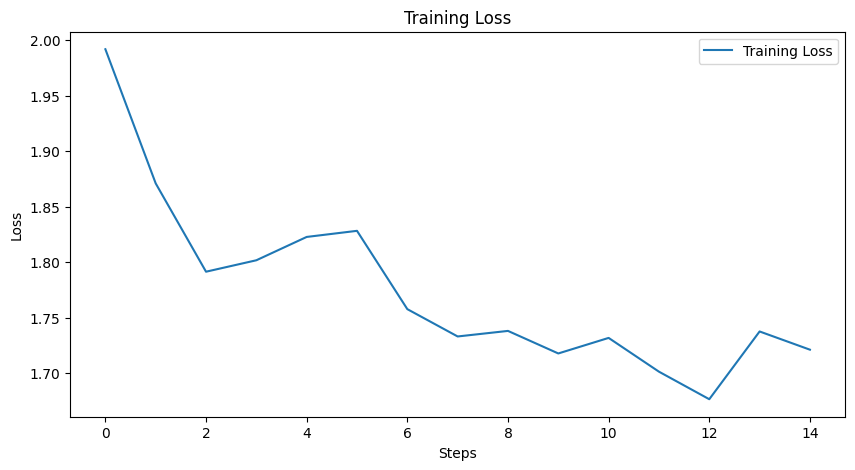

In [44]:
train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

save the model

In [45]:
trainer.save_model("./instruction_tuning_final_model_lora")

Let's redefine the text generation pipeline because the model has been changed to the LoRA model. Ignore the warning for the `PeftModelForCausalLM` not being supported for `text-generation`. However, if the PEFT model is supported, the warning is erroneous.


In [46]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForC

The below code generates tokens with the pipeline using the instruction fine-tuned model. Only three records of data are used for demonstration  because generating text is time consuming on CPU:


In [51]:
with torch.no_grad():
    pipeline_iterator= gen_pipeline(instructions_torch,
                                max_length=50,
                                num_beams=5,
                                early_stopping=True,)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])

In [50]:
generated_outputs_lora[2]

'In Python, you can remove the last item from a list in the following way:'

Let's have a look at some of the responses from the instruction fine-tuned model and the expected responses.


In [52]:
for i in range(3):
    print('--------------------')
    print('----- Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('----- Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('----- Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('\n\n')
    print('--------------------')

--------------------
----- Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.

### Response:




----- Expected response 1: 

The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



----- Generated response 1: 
The most important benefit of using a database system is the ability to store and retrieve data quickly and efficiently.



--------------------
--------------------
----- Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.

### Response:




----- Expected response 2: 

public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    while (i < s.length() && j < x.length()) {
        if (s.charAt(i) == x.charAt(j)) {
            i++;
            j++;
       

Compared to the base model, you can see that the responses are much better. Additionally, the responses don't extend until the maximum number of tokens are generated.

To confirm the responses generated by the instruction fine-tuned model align better with the expected output, let's calculate the SacreBLEU score:


In [53]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs)
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.5


You can see that the fine-tuned model achieves SacreBLEU score which is significantly better than the one achieved by the base model.

Let's conclude. The instruction fine-tuned model generates responses that align much better with the expected responses in the dataset.


---
